In [1]:
# Toy training example

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# graph viz tool
# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
torch.manual_seed(666)
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
# Define 2D Toy Data

# gaussian target parameters
centers = [-0, 0]
sigma = 1

# angle separating the classes
sep_angle = 135

num_samples = 1000

samples_angles = np.random.uniform(low=0, high=180, size=num_samples)
samples_distances = np.random.normal(loc=0, scale=sigma, size=num_samples)

samples_x = [d*np.cos(np.deg2rad(x))+centers[0] for x,d in zip(samples_angles, samples_distances)]
samples_y = [d*np.sin(np.deg2rad(x))+centers[1] for x,d in zip(samples_angles, samples_distances)]

samples_labels = [0 for _ in range(num_samples)]
for s in range(num_samples):
    
    if samples_angles[s]<sep_angle and samples_distances[s]<0:
        samples_labels[s] = 1
    elif samples_angles[s]>=sep_angle and samples_distances[s]>=0:
        samples_labels[s] = 1
    else:
        samples_labels[s] = -1

<IPython.core.display.Javascript object>


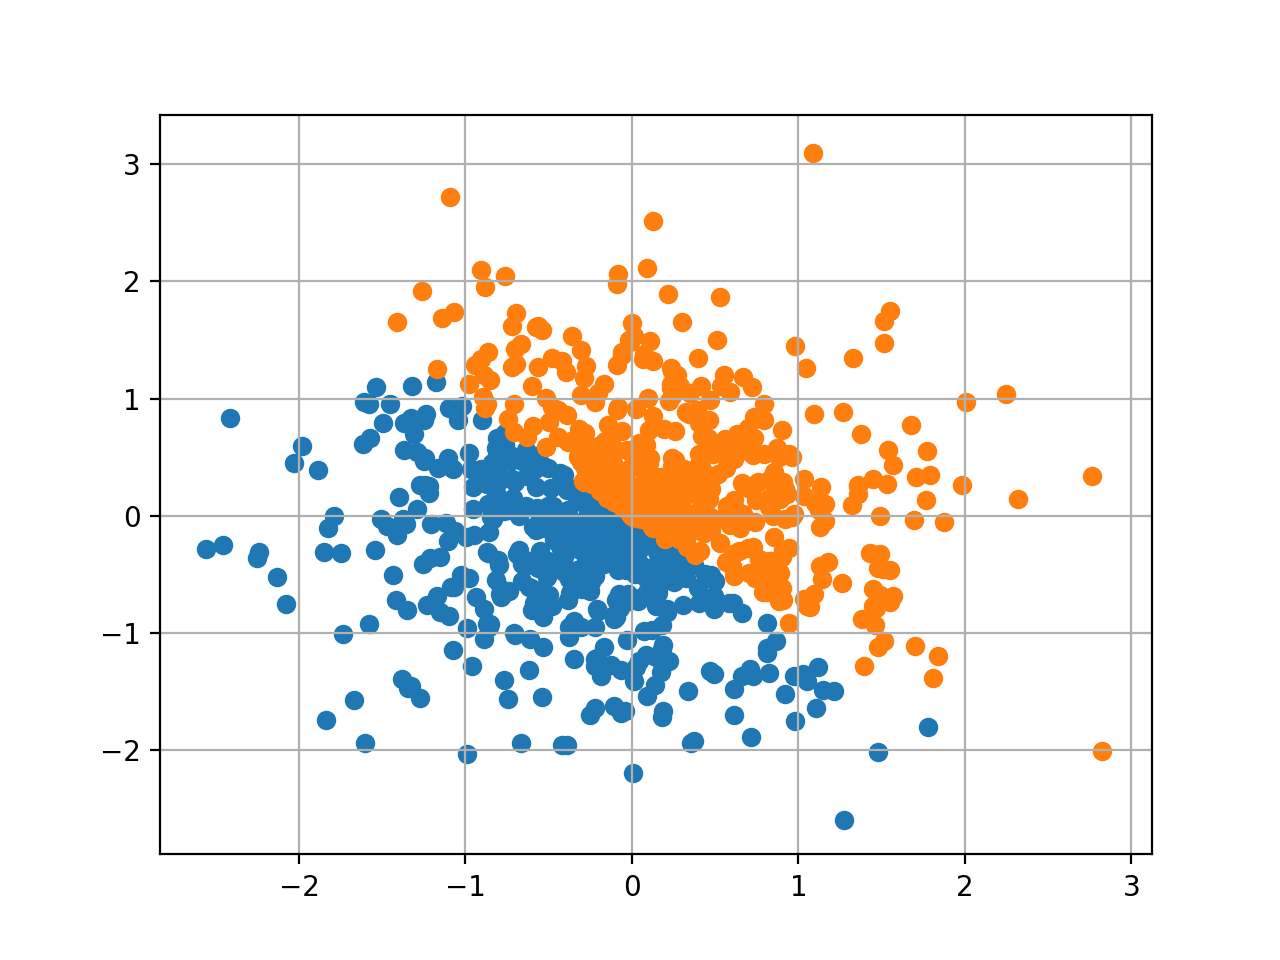

In [7]:
samples_x_1 = [x for x,l in zip(samples_x, samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_y, samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_x, samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_y, samples_labels) if l==-1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [8]:
# convert data to pytorch format 
tensor_x = torch.Tensor(zip(samples_x, samples_y))
tensor_y = torch.Tensor(samples_labels)
# tensor_x = torch.stack([torch.Tensor(i) for i in zip(samples_x, samples_y)]) # transform to torch tensors
# tensor_y = torch.stack([torch.Tensor(i) for i in samples_labels])

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=1) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [9]:
# define the FGN layer class

###
# HARDCODED to be off center but not too far
### 

import math 

class FGN_layer(nn.Module):
    r""" Applies a Finite Gaussian Neuron layer to the incoming data
    
    Args:
    
    Shape:
    
    Attributes:
    
    Examples:
        
        >>> l=FGN_layer(20,30)
    
    """
    def __init__(self, in_features, out_features):
        super(FGN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # learnable parameters
        # regular NN weights (transposed at the start, see order of Tensor(dims))
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad= True)
        # centers of FGNs
        self.centers = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad = True)
        # size of FGNs
        self.sigs = nn.Parameter(torch.Tensor(out_features,), requires_grad = True)
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        # regular NN init
        self.weights.data.uniform_(-1.0, 1.0)
        # centers init
        self.centers.data.uniform_(-3, -3)
        # size init 
        self.sigs.data.uniform_(1.0, 1.0)
        
    def forward(self, input):
        
        # linear part is the same as normal NNs
#         l = nn.functional.linear(input, self.weights, bias=torch.Tensor(self.weights.size()[0]))
        l = nn.functional.linear(input, self.weights, bias=None)
        # optional, apply tanh here
#         l = torch.tanh(l)
#         print("size of L", l.size())
        
        # gaussian component
        g = -((input-self.centers)**2)
        g = g.sum(dim=1)
        g = g/(self.sigs**2)
        g = torch.exp(g)
        g = g.view(l.size())
#         print(g)
        
#         print("size of G", g.size())
        
        g = torch.exp(-((input-self.centers)**2).sum(dim=1)/(self.sigs**2))
        res = l*g
        # optional, flatten res
        # res = F.tanh(res)
#         print("size of L*G", res.size())

        return res
    

In [10]:
# Define a Finite Gaussian Neural Network

class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = FGN_layer(2,1)

    def forward(self, x):
        # input: tensor of ... batch? sample?
        x = self.l1(x)
        x = x.view(1)

        return x

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())

# check weights before training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])

FGNet(
  (l1): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1])]
Training? True
l1
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1])
l1
[-0.37619257 -0.45973182]
[-3. -3.]
[1.]


In [13]:
def train(model, device, train_loader, optimizer, epoch):
    
    # values to return
    weights =  []
    centers = []
    sigmas = []
    weights.append(list(model.l1.weights.view(-1).cpu().detach().numpy()))
    centers.append(list(model.l1.centers.view(-1).cpu().detach().numpy()))
    sigmas.append(list(model.l1.sigs.view(-1).cpu().detach().numpy()))
    
    losses = th.AverageMeter()
    correct = 0
    
    # set model to trainable mode
    model.train()
    # load a batch
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(data,target)
        # load batch data, targets to device
        data, target = data.to(device), target.to(device)
        # reset optimizer gradients
        optimizer.zero_grad()
        # compute predictions
        output = model(data)
#         print(output)
        # compute loss
        loss = F.mse_loss(output, target.float())
        # print(loss)
        
        # update rolling average loss
        losses.update(loss.item(), data.size(0) )
        # update predictions
        pred = torch.Tensor.sign(output)
        correct += pred.eq(target.view_as(pred)).sum().item()        
        
        # propagate gradients
        loss.backward()
#         print("max grad centers:", torch.max(model.l1.centers.grad) )
#         print("max grad sigs:", torch.max(model.l1.sigs.grad) )

        # apply stored gradients to parameters
        optimizer.step()
        
        # print batch stats
#         if batch_idx % (num_samples/5) == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             print("batch:", batch_idx, " Loss", losses.avg)
    
        weights.append(list(model.l1.weights.view(-1).cpu().detach().numpy()))
        centers.append(list(model.l1.centers.view(-1).cpu().detach().numpy()))
        sigmas.append(list(model.l1.sigs.view(-1).cpu().detach().numpy()))
        
        
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        losses.avg, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

    return(weights, centers, sigmas)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target.float())
            pred = torch.Tensor.sign(output)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
# train the model 

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5)

# values to observes
weights_per_update =  []
centers_per_update = []
sigmas_per_update = []

In [15]:
for epoch in range(1, 50):
    print("Epoch:", epoch)
    weights, centers, sigmas = train(model, device, my_dataloader, optimizer, epoch)
    weights_per_update+=weights
    centers_per_update+=centers
    sigmas_per_update+=sigmas
    
    test(model, device, my_test_dataloader)

Epoch: 1
Train set: Average loss: 0.9995, Accuracy: 778/800 (97%)
Test set: Average loss: 0.9986, Accuracy: 193/200 (96%)
Epoch: 2
Train set: Average loss: 0.9992, Accuracy: 780/800 (98%)
Test set: Average loss: 0.9974, Accuracy: 193/200 (96%)
Epoch: 3
Train set: Average loss: 0.9978, Accuracy: 783/800 (98%)
Test set: Average loss: 0.9927, Accuracy: 196/200 (98%)
Epoch: 4
Train set: Average loss: 0.9788, Accuracy: 789/800 (99%)
Test set: Average loss: 0.9096, Accuracy: 196/200 (98%)
Epoch: 5
Train set: Average loss: 0.6585, Accuracy: 790/800 (99%)
Test set: Average loss: 0.5374, Accuracy: 195/200 (98%)
Epoch: 6
Train set: Average loss: 0.4882, Accuracy: 787/800 (98%)
Test set: Average loss: 0.4822, Accuracy: 193/200 (96%)
Epoch: 7
Train set: Average loss: 0.4576, Accuracy: 783/800 (98%)
Test set: Average loss: 0.4615, Accuracy: 193/200 (96%)
Epoch: 8
Train set: Average loss: 0.4428, Accuracy: 782/800 (98%)
Test set: Average loss: 0.4478, Accuracy: 193/200 (96%)
Epoch: 9
Train set: Aver

In [16]:
# check weights after training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])

l1
[-1.8196826 -1.6913015]
[0.0116021  0.02979892]
[1.5374776]


In [17]:
# l1
# [1. 1.]
# [0. 0.]
# [10.]

<IPython.core.display.Javascript object>


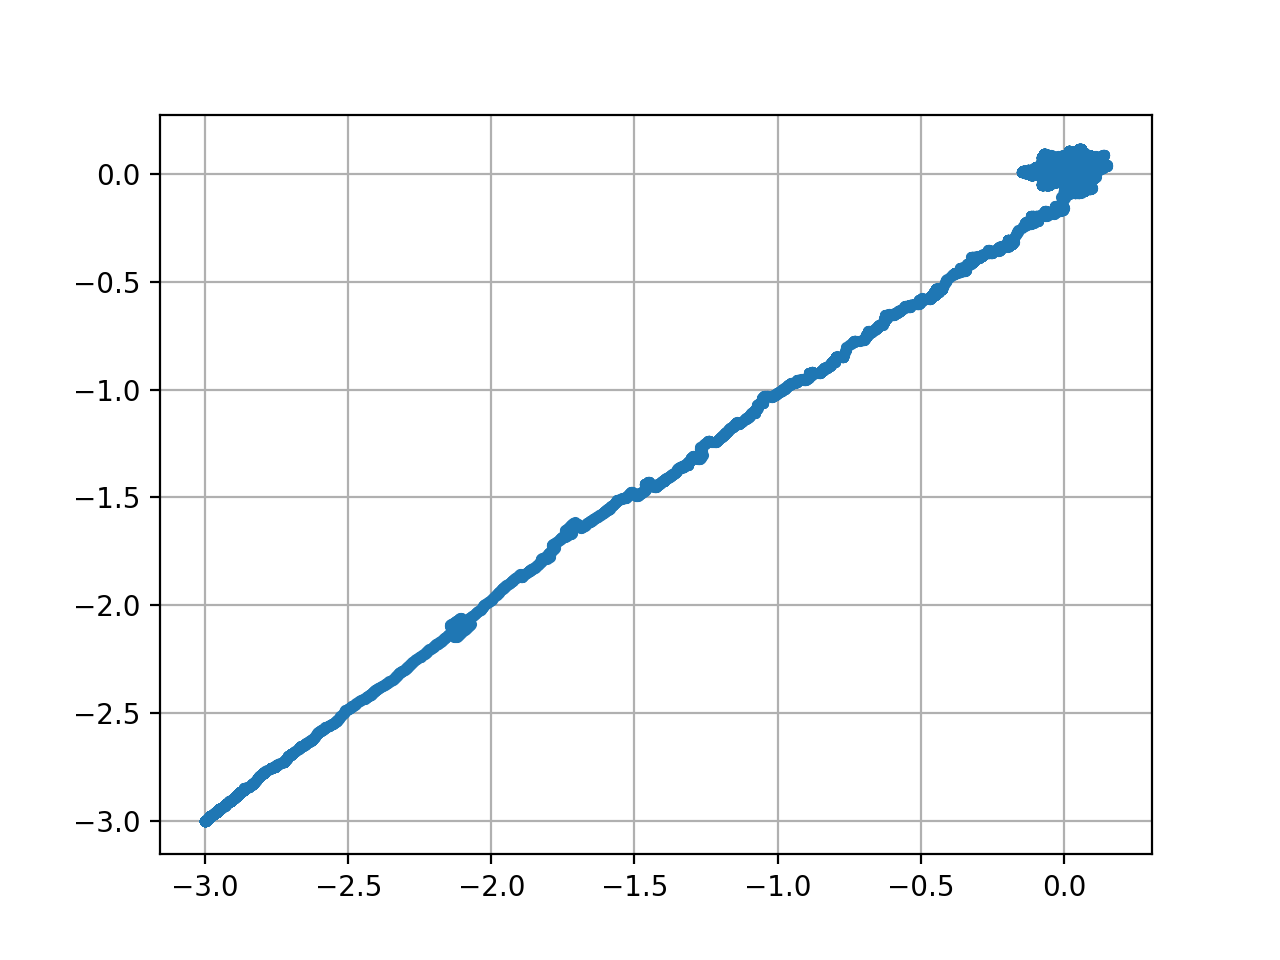

In [20]:
x, y = zip(*centers_per_update)
plt.plot(x,y, marker='.', linestyle=' ')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


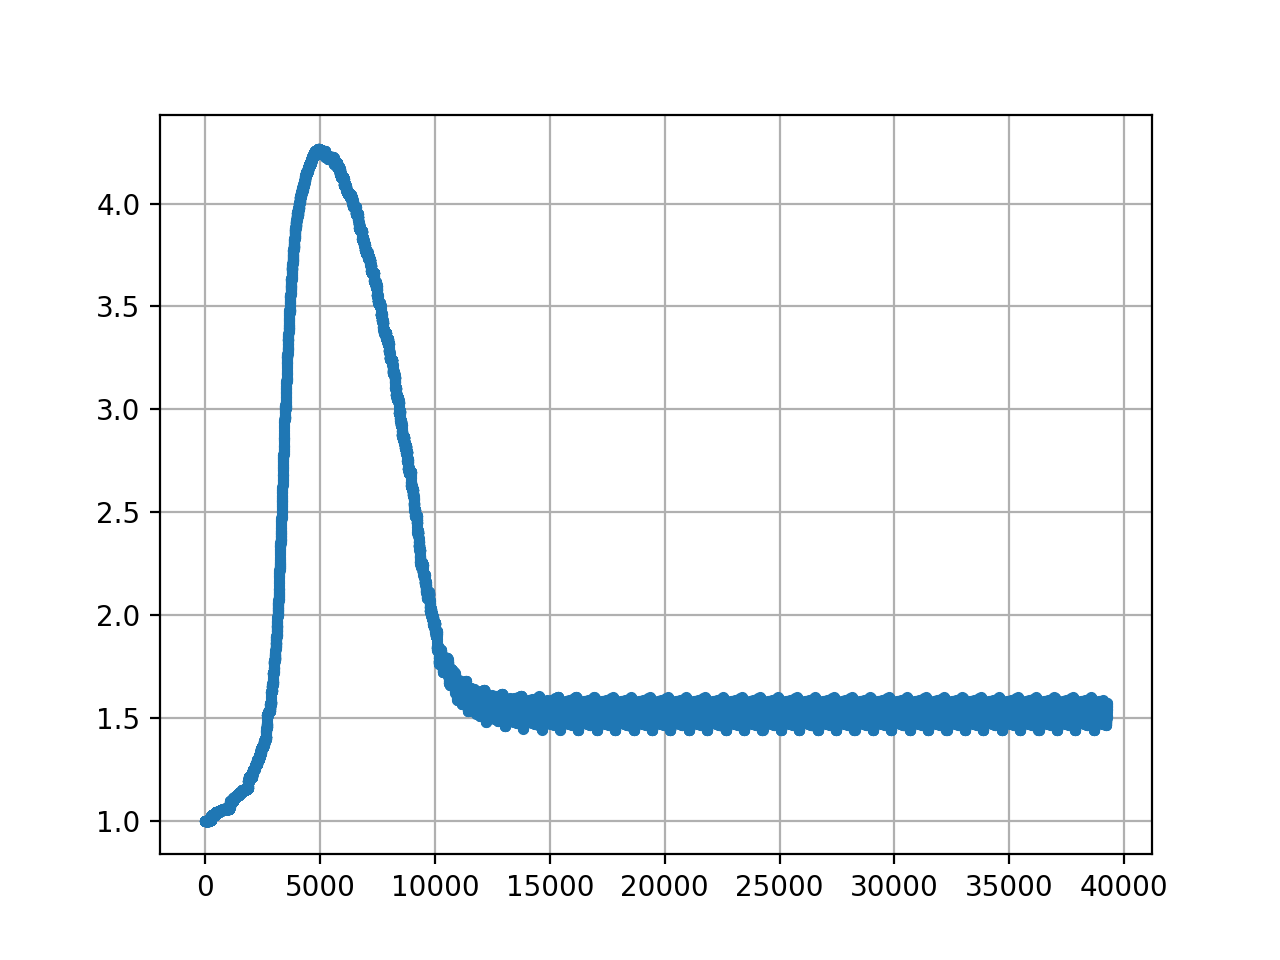

In [21]:
plt.plot(sigmas_per_update, marker='.', linestyle=' ')
plt.grid()
plt.show()